In [4]:
from piazza_api import Piazza
from functools import reduce
from os import environ
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Predicting students enrollment using FCE

### Table of Contents
* [Problem](#problem)
* Data
	* [Web Scraping](#web_scraping)
	* Pre-Processing
        * [Data Pre-processing](#preprocessing)
		* [Grouping](#grouping)
		* [Joining](#joining)
	* [Analysing](#describe)
* Visualizations   
    * [Interesting Patterns](#interesting)
* Features Engineering
    * [Trends](#trends)
	* Type of Courses
		* [Registered Student](#size)
		* [Frequency](#frequency)
	* [Features Importance](#importance)
* Machine Learning    
    * [Prediction](#prediction)
    * [Implementation](#implementation)
* [Results](#results)
* [Conclusion](#conclusion)


<a id='problem'></a>
# Problem

Every semester hundreds of students try to find, the best courses to take. At the same time, they found the reality that they may not be able to enroll in all the courses they want due to quota limits.

We think the registration office may find useful a model which can help them to determine the number of students that will be registering for the following semester. This could help them to plan the number of sections, teachers and resources wanted, and how they could be best allocated.

To achieve this we plan on scraping the Faculty Student Evaluations (FCE) website, as a way of obtaining raw feedbacks from students. In addition, we will also analyze the current trend of technology and include the popularity of topics (e.g. Machine learning, computer vision, etc.) as a weighted feature. With these data, we aim to build a model that helps us predict the number of enrolling students in a course for a given semester.

<a id='web_scraping'></a>
# Web Scraping

We are using a browser driver instead of the request libraries, to be able to bypass CMU authentication.

In [6]:
import os
from time import sleep
# Scrapping Libraries
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [7]:
try:
    os.remove(r'data\table.csv')
except OSError:
    pass

# Change Chrome Download Directory to our repository
path = os.getcwd()
chromeOptions = webdriver.ChromeOptions()
prefs = {"download.default_directory" : r"%s\data" % path}
chromeOptions.add_experimental_option("prefs", prefs)

# Start chrome
chromedriver =r"%s\driver\chromedriver.exe" % path
driver = webdriver.Chrome(executable_path=chromedriver, chrome_options=chromeOptions)

df_raw = None

# -- Control chrome to authenticate with CMU and download the data --

# CMU Authentication
driver.get("https://login.cmu.edu/")

element = WebDriverWait(driver, 20).until(
    EC.presence_of_element_located((By.NAME, "j_username"))
)
u = driver.find_element_by_name('j_username')
u.send_keys(environ['CMU_USER'])

p = driver.find_element_by_name('j_password')
p.send_keys(environ['CMU_PWD'])
p.send_keys(Keys.RETURN)

# Give enouth time so that people with 2FA, can click OK in their phones
element = WebDriverWait(driver, 20).until(
    EC.presence_of_element_located((By.CLASS_NAME, "dataTable"))
)

# Authorize access to FCE
url = 'https://cmu.smartevals.com'
driver.get(url)

# Go to the results web page
url = 'https://wwwp3.smartevals.com/reporting/StudentsSeeResults.aspx'
driver.get(url)

# Download the data in CSV format
select = Select(driver.find_element_by_name('_ctl0:drpExport'))
select.select_by_visible_text('CSV')

# Load the data into a dataframe
file = './data/table.csv'
while not os.path.exists(file):
    sleep(5)
    # Computer takes some time to save to disk, after downloading the file

df_raw = pd.read_csv(file)
df_raw.shape

WebDriverException: Message: 'Project\driver\chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


<a id='preprocessing'></a>
# Data Pre-processing

After scrapping the data, our fist question is, what of these values are incorrect or not helpful and should be removed from our dataset.

1- We will remove the data corresponding to the current semester, because these value are incomplete.

2- We will remove the data from years which have really sparse features. (Since we don't know which years this are, we will set this as parameter for now.

3- Courses which has only being offered 2 or less time. We need at least three data points to be able to see how the change in a feature affect the outocme.
  Ie. How the increase on work hours per week affect the number of enrolled students

4- Departments which no longer exists.

In [492]:
def clean(df, years=[2015, 2016,2017], verbose=True):
    N = 0
    
    # 1- Removes data from the current year
    df = df[df.Year != 2018]
    
    # 2- Only use data for the years we are insterested on
    df = df[df.Year.isin(years)]
    
    # 3- Remove courses offered less than 2 (or N) times
        
    # Count the number of times a course has been offered
    df_count = df.groupby(['Num'])['Semester'].count() 
    
    if verbose:
        for i in range(len(years)):
            N_1 = df_count[df_count == (i+1)].shape[0]
            print('# of courses teached %d time: %d' % (i+1, N_1))

    mask = (df_count[df_count >= len(years)]).index
    df_prune = df[df.Num.isin(mask)]
    
    if verbose:
        N = df_prune.shape[0]
        print('- # of times offered -')
        print('# Removed Rows %d' % (df.shape[0]-N))
        print('# Remaining Rows %d' % (N))
    
    # 4- Departments that does not longer exist
    
    df_depts = df_prune[df_prune.Year == 2017]
    df_depts = df_depts.Dept.unique()
    df_prune = df_prune[df_prune.Dept.isin(df_depts)]
    
    if verbose:
        prev_N = N
        N = df_prune.shape[0]
        print('- Non Existing Depts -')
        print('# Removed Rows %d' % (prev_N-N))
        print('# Remaining Rows %d' % (N))

    return df_prune

In [493]:
df_clean = clean(df_raw, years=range(2013, 2018))

# of courses teached 1 time: 1275
# of courses teached 2 time: 942
# of courses teached 3 time: 679
# of courses teached 4 time: 562
# of courses teached 5 time: 637
- # of times offered -
# Removed Rows 7444
# Remaining Rows 19482
- Non Existing Depts -
# Removed Rows 50
# Remaining Rows 19432


Our scrapped data has easily human readable features, howerver this featues are long and contain spaces, which makes it harder for programming puposes, thus we will rename this column using the below mapping

Data Mapping

`
[('Year', 'year'),
 ('Semester', 'semester'),
 ('Dept', 'dept'),
 ('Num', 'num'),
 ('Section', 'section'),
 ('Name', 'prof'),
 ('Course Name', 'course_name'),
 ('Level', 'level'),
 ('Possible Respondents', 'students'),
 ('Num Respondents', 'answers'),
 ('Response Rate %', 'support'),
 ('Hrs Per Week', 'hrs_week'),
 ('Hrs Per Week 5', 'hrs_week_5'),
 ('Hrs Per Week 8', 'hrs_week_8'),
 ('Interest in student learning', 'prof_interest'),
 ('Clearly explain course requirements', 'course_requirements'),
 ('Clear learning objectives & goals', 'clear_goals'),
 ('Instructor provides feedback to students to improve', 'feedback'),
 ('Demonstrate importance of subject matter', 'subject_importance'),
 ('Explains subject matter of course', 'subject_matter'),
 ('Show respect for all students', 'respect'),
 ('Overall teaching rate', 'teaching_rate'),
 ('Overall course rate', 'course_rate')]
`

In [495]:
def rename_columns(df, cols=None):
    if cols is None:
        df.columns = ['year', 'semester', 'dept', 'num', 'section', 'prof', 'course_name',
           'level', 'students', 'answers', 'support',
           'hrs_week', 'hrs_week_5', 'hrs_week_8',
           'prof_interest', 'course_requirements',
           'clear_goals',
           'feedback',
           'subject_importance',
           'subject_matter', 'respect',
           'teaching_rate', 'course_rate']
    else:
        df.columns = cols
    return df

df_clean = rename_columns(df_clean) 

It will also be useful to know from all the scrape features, which percentage of the data has the given feature. That way we can remove features, which have really small coverage.

In [496]:
def count_nulls(df):
    N = df.shape[0]
    nulls = df.isnull().sum(axis=0)
    results = (nulls/N).sort_values()
    return results
count_nulls(df_clean)

year                   0.000000
semester               0.000000
dept                   0.000000
num                    0.000000
section                0.000000
course_name            0.000000
level                  0.000000
students               0.000000
answers                0.000000
support                0.000000
prof                   0.000051
prof_interest          0.018372
course_requirements    0.018629
clear_goals            0.018681
course_rate            0.018732
teaching_rate          0.018732
feedback               0.018783
subject_importance     0.018783
respect                0.018835
subject_matter         0.018886
hrs_week               0.267754
hrs_week_8             0.751184
hrs_week_5             1.000000
dtype: float64

Also we check if for a particular year, one of the features is considerably sparse. That way we know which years we should remove.

In [497]:
def yearly_count_nulls(df):
    min_year = df.year.min()
    max_year = df.year.max()
    series = []
    for y in range(min_year, max_year+1):
        df_year = df[df.year==y]
        tmp = count_nulls(df_year)
        tmp['C_YEAR'] = y
        series.append(tmp)
    df = pd.concat(series, axis=1) 
   
    df.columns = map(int,a.loc['C_YEAR'].values)
    df = df.drop(['C_YEAR'])

    return df

yearly_count_nulls(df_clean)

,2013,2014,2015,2016,2017
answers,0.000000,0.000000,0.000000,0.000000,0.000000
clear_goals,0.001909,0.011038,0.022444,0.022727,0.029854
course_name,0.000000,0.000000,0.000000,0.000000,0.000000
course_rate,0.001909,0.011313,0.022444,0.022495,0.030089
course_requirements,0.001909,0.011313,0.022688,0.022263,0.029619
dept,0.000000,0.000000,0.000000,0.000000,0.000000
feedback,0.002227,0.011038,0.022444,0.022495,0.030324
hrs_week,1.000000,0.481236,0.022932,0.022032,0.029854
hrs_week_5,1.000000,1.000000,1.000000,1.000000,1.000000
hrs_week_8,0.001909,0.531457,1.000000,1.000000,1.000000


We can see the following features have a really high empty rate. Thus we will remove this features from our dataset.
- Hrs Per Week 5
- Hrs Per Week 8


We can also see that the feature: Hrs Per Week seem to only started to be recorded from 2014 onwards

Also the first two years: 2008 and 2009. Have a more sparse data. 

But appart from these previously mentioned cases, the rest of features showed an emptyness of less thatn 3%.

<a id='grouping'></a>
## Grouping

Our final goal, is to predict how many students will enroll for a course in a given semester. To be able to generate more cohesive features. We will group all the data for the same course, in the same semester. This ways, instead of having a row for each section of the same class, we will have a single record per class.

To do this we will use a weighted average, using the number of responses as the weight for each record.

In [498]:
def group(df, columns=['num', 'year', 'semester'], verbose=True):
    df_2 = df.copy()
    
    numeric_cols = ['hrs_week', 
       'prof_interest', 'course_requirements',
       'clear_goals',
       'feedback',
       'subject_importance',
       'subject_matter', 'respect',
       'teaching_rate', 'course_rate']
    # Scale Up Columns
    
    result = df_2[numeric_cols].values * df_2.answers.values[:,None]
    df_2[numeric_cols] = result
    
    # Group Values
    df_groupped = df_2.groupby(by=columns).agg({
        'course_name': 'first',
        'level': 'first',
        'dept': 'first',
        'section': 'count',
        'prof': pd.Series.nunique,
        'students': 'sum',
        'answers': 'sum',
        'hrs_week': 'sum',
        'prof_interest': 'sum', 
        'course_requirements': 'sum',
        'clear_goals': 'sum',
        'feedback': 'sum',
        'subject_importance': 'sum',
        'subject_matter': 'sum', 
        'respect': 'sum',
        'teaching_rate': 'sum', 
        'course_rate': 'sum',
    })
    
    # Scale Down Columns
    result = df_groupped[numeric_cols].values / df_groupped.answers.values[:,None]
    df_groupped[numeric_cols] = result
    if verbose:
        print('Original Rows', df.shape[0])
        print('Aggregated Rows', df_groupped.shape[0])
        
    return df_groupped.reset_index()
   
df_group = group(df_clean, columns=['num', 'year', 'semester'])

Original Rows 19432
Aggregated Rows 10765


<a id='joining'></a>
## Joining

Finally, we will use the previous semesters performance to predict the next semester enrollment. So we will format our data in a to include several previous years in a same road.

ie.
Instead of having this:
<table>
<tr>
    <th>year</th>
    <th>semester</th>
    <th>num</th>
    <th>course</th>
    <th>students</th>
    <th>response</th>
    <th>course_rate</th>
</tr>
<tr>
    <td>2016</td>
    <td>Spring</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>200</td>
    <td>100</td>
    <td>4.5</td>
</tr>
<tr>
    <td>2016</td>
    <td>Fall</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>300</td>
    <td>100</td>
    <td>4.7</td>
</tr>
</table>


We will have this
<table>
<tr>
    <th>year_0</th>
    <th>semester_0</th>
    <th>num_0</th>
    <th>course_0</th>
    <th>students_0</th>
    <th>year_1</th>
    <th>semester_1</th>
    <th>num_1</th>
    <th>course_1</th>
    <th>students_1</th>    
    <th>response_0</th>
    <th>course_rate_0</th>
</tr>
<tr>
    <td>2016</td>
    <td>Spring</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>200</td>
    <td>2016</td>
    <td>Fall</td>
    <td>15513</td>
    <td>Intro to CS</td>
    <td>300</td>
    <td>100</td>
    <td>4.7</td>
</tr>
</table>

We were careful not to include any of the responses given by students in the year_0 which is the year we will try to predict, given that the students would not have answered any questions in the real world scenario.

In [499]:
def semester_to_int(df):
    dic = {'Fall': 9, 'Spring': 1, 'Summer': 5}
    df['semester_int'] = df.semester.apply(lambda x: dic[x])
    return df

def join(df, previous_n, 
         columns=['num', 'year', 'semester_int'],
         join_columns=['num'],
         verbose=True):
    df = df.sort_values(by=columns)
    
    features = set(df.columns)#-set(columns)
    
    data = []
    N = df.shape[0]
    for idx, row in df.iterrows():
        if idx + previous_n >= N:
            break
            
        new_row = {}
        last_row = df.iloc[idx + previous_n]
        flag = False
        for key in join_columns:
            if row[key] != last_row[key]:
                flag=True
                break
        if flag:
            continue
        
        # Look for the previous offering of this class
        for i in range(previous_n+1):
            row = df.iloc[idx+i]
            
            if (previous_n - i) == 0:
                # Look for the current offering of this class
                for key in columns + ['students']:
                    new_row['0_%s' % (key)] = row[key]
            else:
                for key in features:
                    new_row['%d_%s' % (previous_n-i, key)] = row[key]

        data.append(new_row)
        
    if verbose:
        print('Original Rows', df.shape[0])
        print('Aggregated Rows', len(data))
        
    return pd.DataFrame(data)

# Number of year needed in the dataset
YEARS = 5
# Number of years that are going ot be use as historic information
PREVIOUS_YEARS = YEARS-1

# Group class - same num, semester and year and add some numeric identifier for semester
# Order by num, year (desk), semester
df_group = semester_to_int(df_group)
df_join = join(df_group, PREVIOUS_YEARS, columns=['num', 'year', 'semester_int', 'semester', 'dept'])

Original Rows 10765
Aggregated Rows 3634


Finally, we store this features in disk. In that way, we don't need to re-generate this features.

In [270]:
def save_features(df, filepath=r'.\data\features.csv'):
    df.to_csv(filepath, index=False, encoding='utf-8')
    
save_features(df_join, filepath=r'.\data\features_5_years.csv')

And this is how our data looks:

In [271]:
df_join.head()

,0_dept,0_num,0_semester,0_semester_int,0_students,0_year,1_answers,1_clear_goals,1_course_name,1_course_rate,...,4_num,4_prof_interest,4_respect,4_semester,4_semester_int,4_students,4_subject_importance,4_subject_matter,4_teaching_rate,4_year
0,CB,02201,Spring,1,4,2017,4,4.250000,PRGRMMING SCIENTISTS,3.750000,...,02201,4.17,4.25,Fall,9,17,4.25,3.50,3.67,2014
1,CB,02250,Spring,1,37,2017,17,3.238235,INTRO COMPTNL BIOLGY,3.244118,...,02250,3.72,4.00,Spring,1,32,3.72,3.39,3.50,2013
2,CB,02510,Spring,1,5,2017,3,4.000000,COMPUTATNL GENOMICS,3.670000,...,02510,2.50,4.00,Spring,1,3,5.00,4.50,3.50,2013
3,CB,02510,Fall,9,7,2017,2,3.500000,COMPUTATNL GENOMICS,3.500000,...,02510,4.33,4.33,Spring,1,5,4.33,4.00,4.00,2015
4,CB,02601,Fall,9,26,2017,6,4.000000,PRGRMMING SCIENTISTS,3.830000,...,02601,4.52,4.81,Fall,9,39,4.63,4.41,4.37,2014


<a id='describe'></a>
# What are the properties of our data?

In [242]:
def describe(df):
    N, m = df.shape
    print('Number of Datapoints:', N)
    print('Number of Raw Features:', m)
    
    N_Courses = len(df.num.unique())
    print('\nNumber of Courses:', N_Courses)
    N_Teachers = len(df.prof.unique())
    print('Number of Teachers:', N_Teachers)
    print('Number of Departments:', len(df.dept.unique()))
    
    N_Students = df.students.sum()
    N_Students_Answered = df.answers.sum()
    print('Number of Registration:', N_Students)
    print('Number of Answers:', N_Students_Answered)
    
    print('')
    print('Avg. Courses per Teacher %.2f' % (N_Courses/N_Teachers))
    print('Avg. Students per Course %.2f' % (N_Students/N_Courses))

describe(df_clean)    

Number of Datapoints: 19432
Number of Raw Features: 23

Number of Courses: 1845
Number of Teachers: 2283
Number of Departments: 54
Number of Registration: 479661
Number of Answers: 293984

Avg. Courses per Teacher 0.81
Avg. Students per Course 259.98


## Distributions
This is the distribution of our data for some relevant features.

Let's start with how many times a course has been offered. This way we can determine, if we decide to use 3,4 or 5 years of previous data, how many courses would be left out of our model

In [243]:
def plot_histogram(df, title):
    df.plot.hist(alpha=1,title=title)

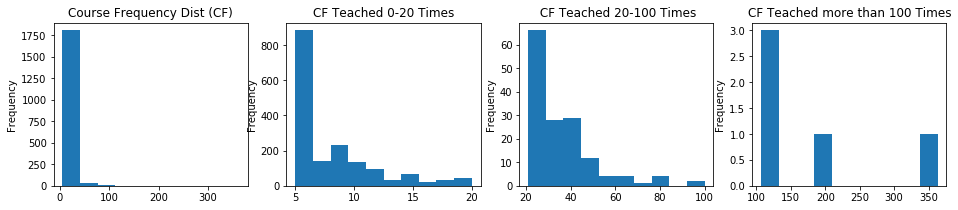

In [248]:
def plot_course_freq_dist(df):
    a = df.groupby(['num'])['dept'].count()#.values
    plt.figure(figsize=(16,3))
    plt.subplot(1,4,1);
    plot_histogram(a,'Course Frequency Dist (CF)')
    
    plt.subplot(1,4,2);
    plot_histogram(a[a <= 20],'CF Teached 0-20 Times')
    plt.subplot(1,4,3);
    plot_histogram(a[(a > 20) & (a <= 100)],' CF Teached 20-100 Times')
    plt.subplot(1,4,4);
    plot_histogram(a[(a > 100)], 'CF Teached more than 100 Times')
    plt.show()

plot_course_freq_dist(df_clean)

Let's see the same frequency but, with the same teacher.

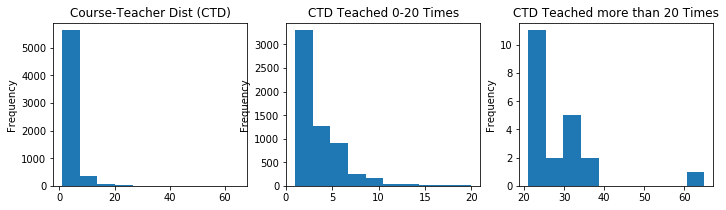

In [251]:
def plot_course_teacher_freq_dist(df):
    a = df.groupby(['num', 'prof'])['dept'].count()
    plt.figure(figsize=(16,3))

    plt.subplot(1,4,1);
    plot_histogram(a, 'Course-Teacher Dist (CTD)')
    plt.subplot(1,4,2);
    plot_histogram(a[a <= 20],'CTD Teached 0-20 Times')
    plt.subplot(1,4,3);
    plot_histogram(a[(a > 20)],'CTD Teached more than 20 Times')
    plt.show()
    
plot_course_teacher_freq_dist(df_clean)    

Finally, let's see what we are here for. What's the registration of students distribution.

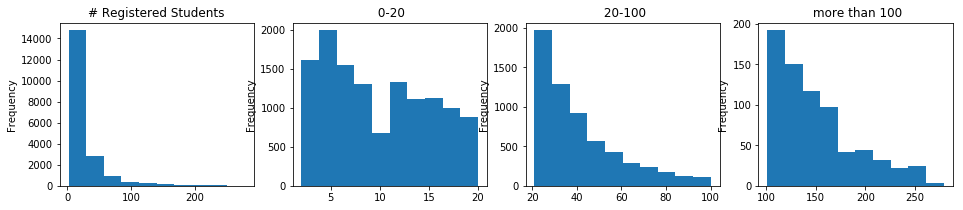

In [252]:
def plot_students_per_course_dist(df):
    a = df.students#.values
    plt.figure(figsize=(16,3))
    plt.subplot(1,4,1);
    plot_histogram(a,'# Registered Students')
    
    plt.subplot(1,4,2);
    plot_histogram(a[a <= 20],' 0-20')
    plt.subplot(1,4,3);
    plot_histogram(a[(a > 20) & (a <= 100)],' 20-100')
    plt.subplot(1,4,4);
    plot_histogram(a[(a > 100)], ' more than 100')
    plt.show()

plot_students_per_course_dist(df_clean)

<a id='visualitzations'></a>
# Visualizations

<a id='interesting'></a>
## Interesting Patterns

<font color='red'>pending!</font> 

<a id='trends'></a>
## Trends

Here we want to look into the trends of classes CMU provided and the of the IT industry and see whether they are connected.

### Top trending technical topics

First, we scrape data from Forbes twitter for the technology trends in the recent 5 years and store the trending topics in “csv” file. Then we process the data and sort it for the top trending technical topics.

In [15]:
import csv
from collections import Counter

forbes_reader = csv.reader(open("./data/tech_trends_forbes.csv", "r"), delimiter=",")
forbes_trends = list(forbes_reader)
forbes_trends = np.array(forbes_trends)

trends_list = []
for row in forbes_trends[1:]:
    for w in row[1:]:
        if w:
            tmp_list = w.split(",")
            trends_list.extend(tmp_list)

trends_counter = Counter(trends_list)
sorted_trends = trends_counter.most_common()

sorted_trends_list = []
for t in sorted_trends:
    sorted_trends_list.append(t[0])

tech_words_list = []
for w in sorted_trends_list:
    w = w.lower()
    tech_words_list.extend(w.split())

# get the set of the top trending tech words
tech_words_set = set(tech_words_list)

print(tech_words_list[:10])

['blockchain', 'vr', 'iot', 'intelligent', 'apps', 'intelligent', 'things', 'ar', 'adaptive', 'security']


Then we want to extract the top trending topic from the classes provided by CMU in recent years.

In [12]:
from rake_nltk import Metric, Rake
from nltk.corpus import stopwords

fce_reader = csv.reader(open("./data/fce.csv", "r"), delimiter=",")
fce = list(fce_reader)
fce = np.array(fce)

with open('./data/courses_ids.json') as f:
    courses_ids = json.load(f)
    
#print(len(courses_ids))
course_num = len(courses_ids)
text = ""
for i in range(course_num):
    text += " "
    text += str(courses_ids[i]['n'])

# Uses stopwords for english from NLTK, and all puntuation characters.
stopWords = set(stopwords.words('english'))

# To use it with English supported by nltk.
r = Rake("english")

# If you want to provide your own set of stop words and punctuations to
r = Rake(stopwords=stopWords)

r.extract_keywords_from_text(text)

#ranked_words = r.get_ranked_phrases_with_scores() # To get keyword phrases ranked highest to lowest.
ranked_words = r.get_ranked_phrases() # To get keyword phrases ranked highest to lowest.

print(ranked_words[:3])


['experimentalists differential geometry mathematical studies analysis ii geographic information systems engineering run time malware detection behavioral decision making tissue engineering opera literature sustainable design synthesis prep guest experience', 'test class test class 2 test 3 test 4 test 4 test 5 research advanced digital design systems research using nsf probe experimental clusters test class', 'complex communication systems data warehousing mscf options 08705 msit ebiz round2 first year seminar software design formal methods ii relationships 101 choices']


In [14]:
class_terms = []

for w in ranked_words:
    w = w.lower()
    class_terms.extend(w.split(" "))

term_counter = Counter(class_terms)
sorted_terms = term_counter.most_common()
top_class_name_terms = []

for t in sorted_terms:
    if t[0] in tech_words_set:
        if t[0] == 'learning':
            top_class_name_terms.append('machine learning')
        elif t[0] != 'machine':
            top_class_name_terms.append(t[0])

print(top_class_name_terms[:10])

['systems', 'data', 'computing', 'advanced', 'machine learning', 'information', 'security', 'analytics', 'architecture', 'digital']


In order to present the top trending words more clearly, we use WordCloud to visualize the words extracted from the two sources.

-------- Class Tech Words --------


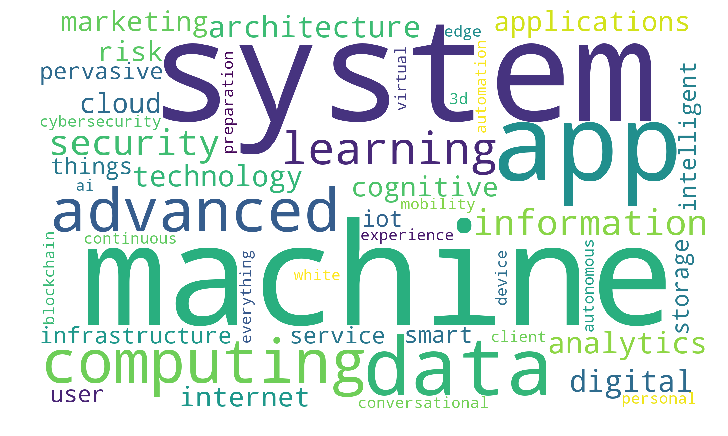

-------- Trending Tech Words --------


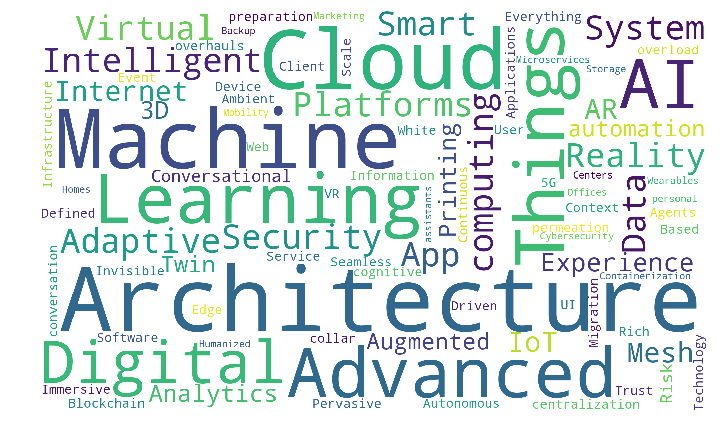

In [18]:
# import the word cloud generator and matploylib
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

def draw_cloud(cleaned_data, fig_name, color = 'white', map_color = 'viridis'):
    words = ' '.join(cleaned_data)
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = color,
                      width = 2000, height = 1200, colormap = map_color).generate(words)
    plt.figure(1, figsize = (12, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    #plt.savefig(fig_name)
    plt.show()

# Plot the word clouds
print("-------- Class Tech Words --------")
draw_cloud(top_class_name_terms, 'classname_wordcloud')
print("-------- Trending Tech Words --------")
draw_cloud(sorted_trends_list, 'trends_wordcloud')

<a id='feature'></a>
# Feature Engineering

<a id='course_type'></a>
## Type of Courses

A type of feature we can use is to cluster our data, using distinct categories such as:

- Based on size of Registered Student
    - Courses with less than 10 Students
    - Courses with less than 20 Students
    - Courses with less than 30 Students
    - Courses with less than 50 Students
    - Courses with less than 100 Students
    - Courses with less than 300 Students
    - Courses with more than 300 Students
    
    
- Based on frequency
    - Courses that are offered Once a year
    - Courses that are offered Twice a year
    - Courses that are offered Three times a year
    
    
- Based on change in student registration
    - Courses that always have small change
    - Courses that have big change

<a id='size'></a>
### Size of Registered Student

In [272]:
def set_size_category(df, years=3, ranges=[10,20,30,50,100,300,1000]):
    df_new = pd.DataFrame()
    
    df_new['students_max'] = df['1_students']
    df_new['students_avg'] = 0
    for i in range(1,years-1):
        df_new['students_avg'] += df['%d_students' % i] 
        df_new['students_max'] = np.maximum(df_new['students_max'].values, df['%d_students' % i].values)
    
    df_new['students_avg'] = df_new['students_avg']/(years-1)
    
    def category(value):
        for i, val in enumerate(ranges):
            if value < val:
                return i
        return len(ranges)
        
    df['students_avg_category'] = df_new.students_avg.apply(category)
    df['students_max_category'] = df_new.students_max.apply(category)
    df['students_avg'] = df_new.students_avg
    df['students_max'] = df_new.students_max
    
    return df_new

set_size_category(df_join, years=5)    
df_join.groupby('students_max_category')[['0_num']].count()

,0_num
students_max_category,
0,447
1,711
2,456
3,558
4,573
5,696
6,190
7,3


<a id='frequency'></a>
### Frequency

In [273]:
def set_frequency(df, years=3):
    df_new = pd.DataFrame()
    
    def semester_one_hot_encoding(row):
        dic = dict(Fall=1, Summer=10, Spring=100)
        fall = False
        result = ['0']*3

        for i in range(years):
            if row['%d_semester_int'%i] == 9:# 'Fall':
                result[2] = '1'
                break
        for i in range(years):
            if row['%d_semester_int'%i] == 5:#'Summer':
                result[1] = '1'
                break
        for i in range(years):
            if row['%d_semester_int'%i] == 1:#'Spring':
                result[0] = '1'
                break

        return ''.join(result)

    df_new['frequency'] = df.apply(semester_one_hot_encoding, axis=1)
    df['frequency'] =  df_new.frequency
    return df_new

df = set_frequency(df_join, years=5)
df['dummy'] = 1
df.groupby('frequency').count()

,dummy
frequency,
001,404
010,3
011,96
100,372
101,1920
110,68
111,771


<a id='change'></a>
### Change in Students Registration 

In [274]:
def set_delta_students(df, years=3):
    df_new = pd.DataFrame()
    
    for i in range(1,years-1):
        df_new['delta_students_%d' % i] = (df['%d_students' % i] - df['%d_students' % (i+1)])/df['%d_students' % (i+1)]

    df_new['delta_students'] = 0
    for i in range(1,years-1):
        df_new['delta_students'] += df_new['delta_students_%d' % i].abs()
    
    def category(value):
        value = abs(value)
        if value == 0:
            return 0
        elif value <= 0.5:
            return 1
        elif value <= 1:
            return 2
        elif value <= 10:
            return 3
        elif value <= 100:
            return 4
        else:
            return 5
        
    df_new['delta_category'] = df_new.delta_students.apply(category)
    
    df['delta_students'] = df_new.delta_students
    df['delta_category'] = df_new.delta_category

    return df_new

df = set_delta_students(df_join, years=5)   
df_join.groupby('delta_category')[['0_num']].count()

,0_num
delta_category,
0,12
1,486
2,730
3,2000
4,402
5,4


<a id='importance'></a>
## Features Importance

Here we are plotting how the change in one feature after the number of students registered

In [262]:
def check_delta(df, feature, years=3):
    df_new = pd.DataFrame()
    
    for i in range(1,years-1):
        dif = (df['%d_%s' % (i, feature)] - df['%d_%s' % (i+1, feature)])
        df_new['delta_%s_%d' % (feature, i)] =dif/df['%d_%s' % (i+1, feature)]

    df_new['delta_feature'] = 0
    for i in range(1,years-1):
        df_new['delta_feature'] += df_new['delta_%s_%d' % (feature, i)].abs()
    
    return df_new


In [265]:
df = check_delta(df_join, 'students')
df.head()

,delta_students_1,delta_feature
0,-0.200000,0.200000
1,1.916667,1.916667
2,0.000000,0.000000
3,0.250000,0.250000
4,-0.695652,0.695652


In [267]:
df.columns

Index(['0_num', '0_semester', '0_semester_int', '0_students', '0_year',
       '1_answers', '1_clear_goals', '1_course_name', '1_course_rate',
       '1_course_requirements', '1_dept', '1_feedback', '1_hrs_week',
       '1_level', '1_num', '1_prof_interest', '1_respect', '1_semester',
       '1_semester_int', '1_students', '1_subject_importance',
       '1_subject_matter', '1_teaching_rate', '1_year', '2_answers',
       '2_clear_goals', '2_course_name', '2_course_rate',
       '2_course_requirements', '2_dept', '2_feedback', '2_hrs_week',
       '2_level', '2_num', '2_prof_interest', '2_respect', '2_semester',
       '2_semester_int', '2_students', '2_subject_importance',
       '2_subject_matter', '2_teaching_rate', '2_year', '3_answers',
       '3_clear_goals', '3_course_name', '3_course_rate',
       '3_course_requirements', '3_dept', '3_feedback', '3_hrs_week',
       '3_level', '3_num', '3_prof_interest', '3_respect', '3_semester',
       '3_semester_int', '3_students', '3_subjec

Category 3


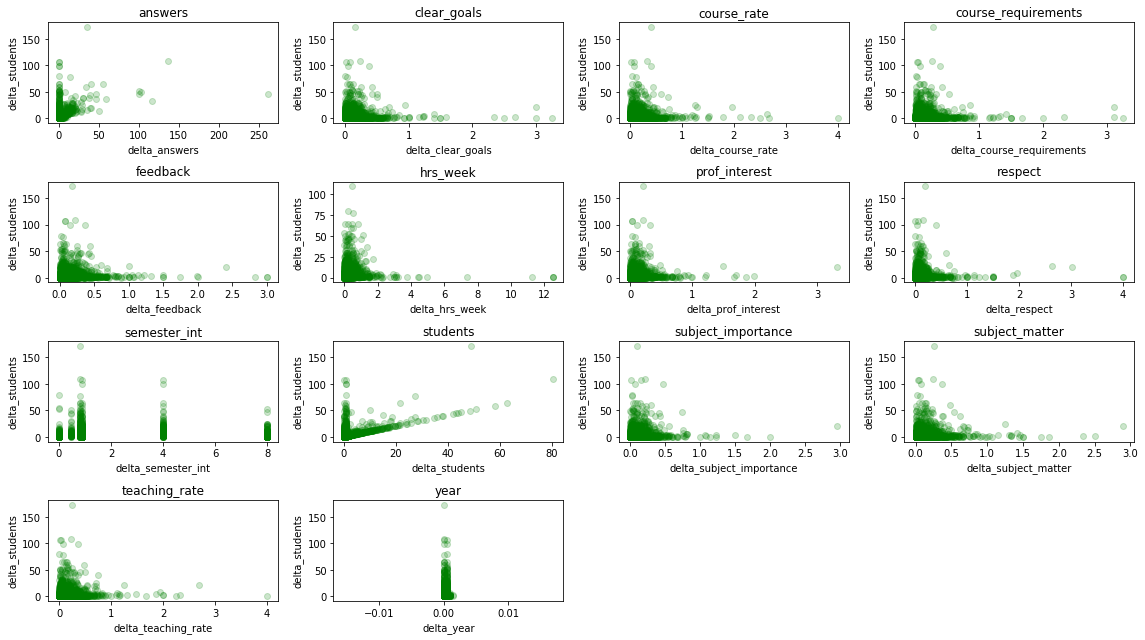

Category 2


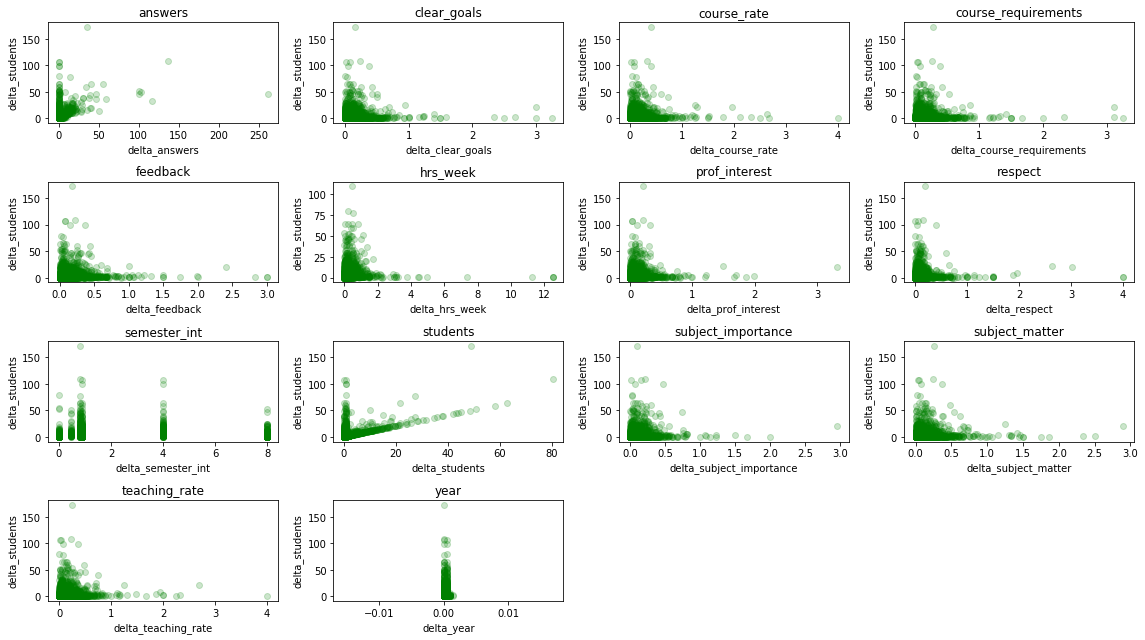

Category 1


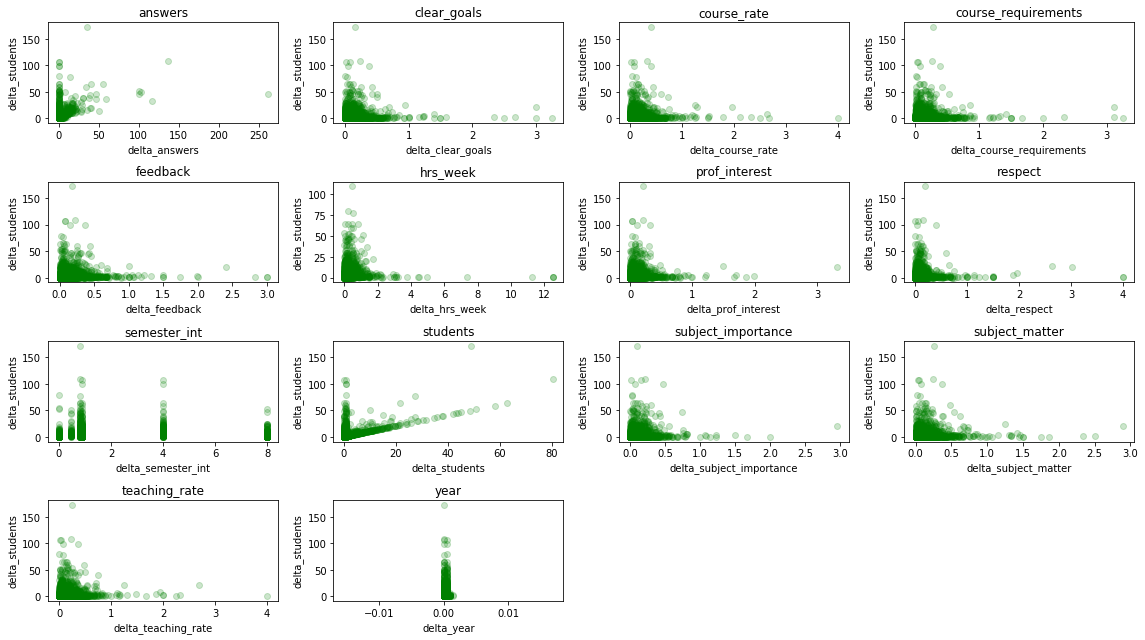

Category 4


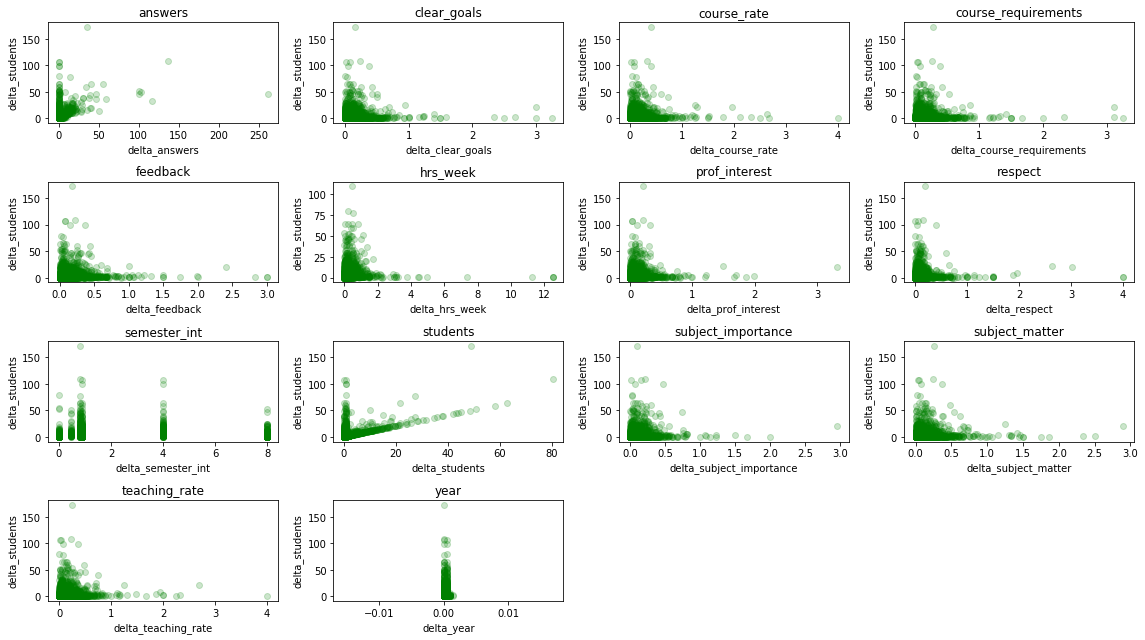

Category 0


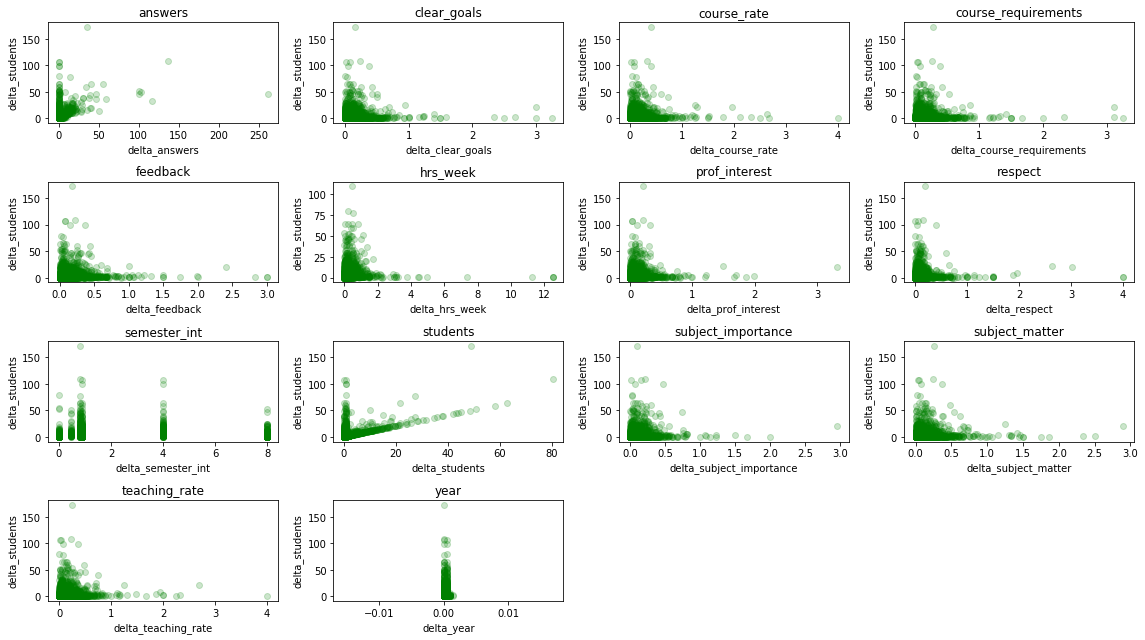

Category 5


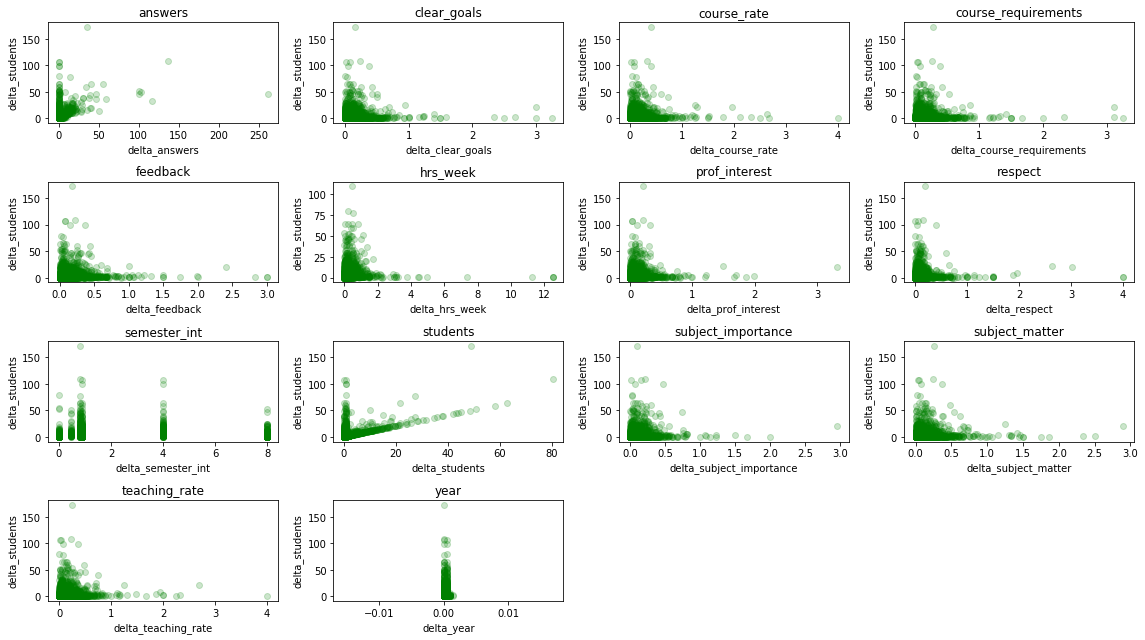

In [277]:
for cat in df_join.delta_category.unique():
    idx = 1
    plt.figure(figsize=(16,9))

    print('Category', cat)
    df = df_join[df_join.delta_category == cat]

    for i, col in enumerate(df_join.columns):
        if col[:2] != '1_' :
            continue

        col = col[2:]
        
        # Ignore string features
        if col  in {'dept', 'course_name', 'level', 'num', 'semester'}:
            continue
            
        df = check_delta(df_join, col)
        plt.subplot(4,4,idx)
        plt.scatter(df.delta_feature, df_join.delta_students, c="g", alpha=0.2,)
        plt.xlabel("delta_%s" % col)
        plt.ylabel("delta_students")
        plt.title(col)
    #     plt.legend(loc=2)

        idx += 1
    plt.tight_layout()
    plt.show()
    

Here we can see that the previous change in students is the only feature which has a strong correlation with the future change in students.

The previous change in other features does not show such a strong relation.

<a id='prediction'></a>
# Prediction

In [278]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

First, let's encode transform our string features into integers

In [282]:
def encode(df, keys_to_encode=[], remove=[], verbose=True):
    le = {}
    data = df.copy(deep=True)
    
    for key, values in remove:
        for value in values:
            data = data[df[key] != value]
    
    for key in keys_to_encode:
        le[key] = LabelEncoder()
        le[key].fit(data[key].values)
        data[key] = le[key].transform(data[key].values)    

    if verbose:
        for key in keys_to_encode:
            print(key, le[key].classes_)

    return data, le 

Second let's split our data into a training and a texting set

In [283]:
def split(X,y,n_splits=10, standardized_flag=True, verbose=False):
    y = y.values
    if standardized_flag:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    skf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    skf.get_n_splits(X)
    
    scores = []
    
    max_score = 0
    max_clf = None
    max_data = None
    max_labels = None
    max_predict = None
    
    for train_index, test_index in skf.split(X, y):
        train_x, test_x = X[train_index], X[test_index]
        train_y, test_y = y[train_index], y[test_index]
        return train_x, test_x, train_y, test_y
#     return np.mean(scores)#, max_score, max_clf, max_data, max_label, max_predict

In [364]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

def train(X,Y,standardized_flag=True,cols=[], verbose=True):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    train_x, test_x, train_y, test_y = split(X,Y, standardized_flag=standardized_flag)
    # Train the model using the training sets
    regr.fit(train_x, train_y)

    # Make predictions using the testing set
    pred_y = regr.predict(test_x)

    # The coefficients
    if verbose and COEFFICIENTS:
        print('Coefficients:')
#         for a,b in  sorted(list(zip(cols,regr.coef_)), key=lambda x:x[1])[:3]+sorted(list(zip(cols,regr.coef_)), key=lambda x:x[1])[-3:]:
        for a,b in  sorted(list(zip(cols,regr.coef_)), key=lambda x:x[1]):
            print('%s\t\t%.2f' % (a,b))

    mse = mean_squared_error(test_y, pred_y) 
    rmse = mse ** 0.5
    r2 =  r2_score(test_y, pred_y)
    accuracy = (np.abs(test_y - pred_y) <= 10).mean()
    accuracy2 = (np.abs(test_y - pred_y) <= 20).mean()
    accuracy3 = (np.abs(test_y - pred_y) <= 30).mean()

    if verbose:
        # The mean squared error
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse)
        print('Variance Score: %.2f' % r2) # Explained variance score: 1 is perfect prediction
        print("Accuracy: %.2f" % accuracy)
        print("Accuracy+-20: %.2f" % accuracy2)
        print("Accuracy+-30: %.2f" % accuracy3)
        
    return regr, mse, rmse, r2


def tree_train(X,Y,standardized_flag=True,cols=[], verbose=True):
    train_x, test_x, train_y, test_y = split(X,Y, standardized_flag=standardized_flag)
    
    # Create the dataset
    rng = np.random.RandomState(1)
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=4)

    regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                              n_estimators=300, random_state=rng)

    regr_1.fit(train_x, train_y)
    regr_2.fit(train_x, train_y)

    # Predict
    pred_y_1 = regr_1.predict(test_x)
    pred_y = regr_2.predict(test_x)

    mse = mean_squared_error(test_y, pred_y_1) 
    rmse = mse ** 0.5
    r2 =  r2_score(test_y, pred_y_1)
    
    
    if verbose:
        print("Without Boosting")
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse)
        print('Variance Score: %.2f' % r2) # Explained variance score: 1 is perfect prediction
    
    
    mse = mean_squared_error(test_y, pred_y) 
    rmse = mse ** 0.5
    r2 =  r2_score(test_y, pred_y)

    if verbose:
        # The mean squared error
        print("With Boosting")        
        print("MSE: %.2f" % mse)
        print("RMSE: %.2f" % rmse)
        print('Variance Score: %.2f' % r2) # Explained variance score: 1 is perfect prediction
    return regr_2, mse, rmse, r2


def grouped_train(df, feature='dummy', verbose=True, tree=True):
    df['dummy'] = 1

    total_n = 0
    mse_total = 0
    for name, group in df.groupby(feature):
        N = group.shape[0]
        if verbose:
            print('~'*60)
            print(feature, name, ' Size: %d ' % N)

        if (group.shape[0] < 10):
            if verbose:
                print('skipped')
                print(group[cols])
            continue

        total_n += N
        # Split Data in Features and Label
        X, Y = group, group.pop('0_students')

        X = X.fillna(0)
        cols = X.columns
        if tree:
            _, mse, rmse, r2 = tree_train(X.values,Y,standardized_flag=False, cols=cols, verbose=verbose)
        else:
            _, mse, rmse, r2 = train(X.values,Y,standardized_flag=False, cols=cols, verbose=verbose)
        mse_total += mse*N
    
    if verbose:
        print('\nTOTAL RMSE', (mse_total/total_n)**0.5)
    return (mse_total/total_n)**0.5
    

<a id='implementation'></a>
# Implementation

In [530]:
# Get Data
df_raw = pd.read_csv('./data/fce.csv')
df_clean = clean(df_raw, years=range(2018-5, 2018))
del df_raw

# of courses teached 1 time: 1275
# of courses teached 2 time: 942
# of courses teached 3 time: 679
# of courses teached 4 time: 562
# of courses teached 5 time: 637
- # of times offered -
# Removed Rows 7444
# Remaining Rows 19482
- Non Existing Depts -
# Removed Rows 50
# Remaining Rows 19432


In [552]:
# Encode
# TODO: Make the copy inside
df_rename = rename_columns(df_clean.copy(deep=True))

# Pre-Pruning
df_rename = df_rename[df_rename.semester != 'Summer'] 
df_rename = df_rename[df_rename.num != '15637'] 
df_rename = semester_to_int(df_rename)

# TODO: Add to a function
df_rename = df_rename[~df_rename.prof.isnull()]

df_encoded = df_rename
df_encoded, encoders = encode(df_rename, keys_to_encode=['course_name', 'level', 'num', 'semester', 'dept','prof'], verbose=False) 

In [553]:
# Group Data
YEARS = 5
df_group = group(df_encoded, columns=['num', 'year', 'semester_int', 'semester'])
df_join = join(df_group, YEARS-1, columns=['num', 'year', 'semester_int', 'semester'])

# Pruning
# df_join['tmp_delta'] = df_join['0_students'] - df_join['1_students']
# print('>100', (df_join.tmp_delta.abs() > 100).sum(), '<100', (df_join.tmp_delta.abs() <= 100).sum())
# df_join = df_join[df_join.tmp_delta.abs() <= 50]

# Group Data + Profesor
# df_group_prof = group(df_encoded, columns=['num', 'year',  'semester_int', 'semester', 'prof'])
# df_join_prof = join(df_group_prof, 4, columns=['num', 'year',  'semester_int', 'semester', 'prof'], join_columns=['num', 'prof'])

Original Rows 18504
Aggregated Rows 10209
Original Rows 10209
Aggregated Rows 3144


In [556]:
# Add Features
set_size_category(df_join, years=YEARS)    
set_frequency(df_join, years=YEARS)
set_delta_students(df_join, years=YEARS)    

# Save Data
save_features(df_join, filepath=r'.\data\features_%d_years_v2.csv' % YEARS)

In [557]:
# Before Training
df = df_join.copy(deep=True)

# Split Data in Features and Label
X, Y = df, df.pop('0_students')

X = X.fillna(0)
cols = X.columns

In [561]:
# Training
# print('Size',X.shape[0])
# _, mse, rmse, accu = train(X.values,Y,standardized_flag=False, cols=cols, verbose=True)

# Exclude Summers
features = [
    'students',
#     'level',
#     'dept',
#     'answers',
#     'course_rate',
#     'year'
#     'hrs_week',
#     'num',
#     'semester',
#     'semester_int',
#     'clear_goals',
#     'course_name',
#     'course_requirements',
#     'feedback',
#     'prof_interest',
#     'respect',
#     'subject_importance',
#     'subject_matter',
#     'teaching_rate',
]
df = df_join.copy(deep=True)

feats = ['%d_%s' % (y,f) for f in features for y in range(1,YEARS)]
#     for c in df.columns:
#         if feat in c:
#             del df[c]
#             print(c, end=' ')

# frequency
df = df[feats + ['0_students', '0_num', '0_semester_int', '0_year', 
                 'students_avg_category', 'students_avg',
                 'students_max_category', 'students_max', 
                 'frequency', 'delta_students', 'delta_category']]

# def tmp():
if True:
    # df['split'] = (df.students_max_category > 2)*1
    # df['split'] = (df.students_max_category > 3)*1
    df['split'] = 0
    df.loc[df.students_max_category.values <= 4,'split'] = 100
    df.loc[df.students_max_category == 5, 'split'] = 300

    big_boys = df.loc[df.split == 300]
    tmp = encoders['num'].inverse_transform(list(map(int,big_boys['0_num'].values)))
    big_boys['num'] = tmp
    tmp  = 300 + (big_boys.num.str[-3] == '1')*1
    df.loc[df.split == 300, 'split'] = tmp 

    df.loc[df.students_max_category > 5, 'split'] = 1000

    big_boys = df.loc[df.split == 1000]
    tmp = encoders['num'].inverse_transform(list(map(int,big_boys['0_num'].values)))
    big_boys['num'] = tmp
    tmp  = 1000 + (big_boys.num.str[-3] == '1')*1
    df.loc[df.split == 1000, 'split'] = tmp 
else:
    df['split'] = 0
    df['split'] = encoders['num'].inverse_transform(list(map(int,df['0_num'].values)))
    df['split'] = df.split.str[-3]
    
# df['split'] = (df.students_max_category > 6)*3
COEFFICIENTS=False
grouped_train(df, feature='split', verbose=True, tree=False)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 100  Size: 2510 
MSE: 317.21
RMSE: 17.81
Variance Score: 0.53
Accuracy: 0.82
Accuracy+-20: 0.94
Accuracy+-30: 0.96
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 300  Size: 417 
MSE: 1752.01
RMSE: 41.86
Variance Score: 0.59
Accuracy: 0.19
Accuracy+-20: 0.36
Accuracy+-30: 0.55
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 301  Size: 98 
MSE: 1058.94
RMSE: 32.54
Variance Score: 0.81
Accuracy: 0.30
Accuracy+-20: 0.70
Accuracy+-30: 0.90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 1000  Size: 56 
MSE: 3211.57
RMSE: 56.67
Variance Score: 0.81
Accuracy: 0.00
Accuracy+-20: 0.00
Accuracy+-30: 0.33
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 1001  Size: 63 
MSE: 16055.56
RMSE: 126.71
Variance Score: 0.67
Accuracy: 0.00
Accuracy+-20: 0.29
Accuracy+-30: 0.43

TOTAL RMSE 29.9592663561


C:\Users\delac\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\delac\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


29.959266356096503

In [541]:
big_boys['0_num'].values

array([   18.,    18.,    18.,    18.,    18.,    18.,   163.,   163.,
         191.,   191.,   191.,   191.,   191.,   191.,   193.,   292.,
         292.,   292.,   292.,   292.,   292.,   293.,   293.,   293.,
         293.,   293.,   293.,   295.,   295.,   295.,   295.,   295.,
         295.,   299.,   299.,   301.,   301.,   301.,   301.,   301.,
         301.,   302.,   302.,   302.,   302.,   302.,   302.,   305.,
         305.,   305.,   305.,   305.,   332.,   339.,   339.,   344.,
         344.,   345.,   345.,   425.,   426.,   428.,   552.,   552.,
         552.,   552.,   552.,   552.,   556.,   556.,   556.,   556.,
         556.,   556.,   567.,   567.,   567.,   567.,   567.,   567.,
         683.,   683.,   737.,   737.,   737.,  1245.,  1245.,  1245.,
        1309.,  1309.,  1309.,  1309.,  1309.,  1404.,  1405.,  1459.,
        1459.,  1459.,  1459.,  1459.,  1459.,  1475.,  1475.,  1475.,
        1475.,  1475.,  1475.,  1523.,  1523.,  1523.,  1523.,  1523.,
      

In [516]:
code = encoders['num'].transform(['10601'])[0]
code
# df[df['0_num'] == code]

191

In [464]:
courses = df[df.split == 1000]['0_num'].unique() #  ['split', '0_num']]
courses = list(map(int, courses))
len(courses)

courses = encoders['num'].inverse_transform(courses)
courses = courses# list(map(int, courses))
courses
# courses
# df[['split', '0_num']]

array(['03121', '09105', '10601', '10701', '15110', '15112', '15122',
       '15150', '15210', '15213', '15251', '15451', '15513', '15619',
       '15637', '18100', '18200', '18213', '21120', '21127', '21259',
       '33106', '36217', '57418', '57818', '67373', '67475', '73100',
       '76101', '79104', '85102', '94700', '95702'], dtype=object)

In [513]:
for i in ['03121', '09105', '10601', '10701', '15110', '15112', '15122',
       '15150', '15210', '15213', '15251', '15451', '15513', '15619',
       '15637', '18100', '18200', '18213', '21120', '21127', '21259',
       '33106', '36217', '57418', '57818', '67373', '67475', '73100',
       '76101', '79104', '85102', '94700', '95702']:
    print(i[:2],i[2],i[3:])

03 1 21
09 1 05
10 6 01
10 7 01
15 1 10
15 1 12
15 1 22
15 1 50
15 2 10
15 2 13
15 2 51
15 4 51
15 5 13
15 6 19
15 6 37
18 1 00
18 2 00
18 2 13
21 1 20
21 1 27
21 2 59
33 1 06
36 2 17
57 4 18
57 8 18
67 3 73
67 4 75
73 1 00
76 1 01
79 1 04
85 1 02
94 7 00
95 7 02


In [517]:
df_group[df_group.num == 191] #339, 345

,num,year,semester_int,semester,course_name,level,dept,section,prof,students,...,hrs_week,prof_interest,course_requirements,clear_goals,feedback,subject_importance,subject_matter,respect,teaching_rate,course_rate
977,191,2013,1,1,1177,0,40,1,1,133,...,NaN,4.490000,4.390000,4.430000,4.200000,4.480000,4.470000,4.580000,4.410000,4.290000
978,191,2013,9,0,1177,0,40,2,2,326,...,NaN,3.525000,3.240000,3.325000,3.145000,3.525000,3.330000,3.865000,3.295000,3.015000
979,191,2014,1,1,1177,0,40,2,2,195,...,NaN,4.415000,4.279776,4.387388,3.985821,4.406866,4.265075,4.528284,4.221269,4.168806
980,191,2014,9,0,1177,0,40,2,2,208,...,12.685072,3.910580,3.781957,3.964275,3.628478,4.025000,3.627029,4.295725,3.679130,3.651739
981,191,2015,1,1,1177,0,40,3,3,422,...,13.051034,4.484483,4.341379,4.354483,4.241034,4.470345,4.274483,4.595172,4.250000,4.346207
982,191,2015,9,0,1177,0,40,5,3,457,...,12.503940,3.993463,3.890955,3.905224,3.753284,4.029433,3.752866,4.421970,3.688627,3.747522
983,191,2016,1,1,1177,0,40,5,5,434,...,13.300997,4.287717,4.192637,4.219678,3.978199,4.365145,4.160354,4.523762,4.069582,4.224084
984,191,2016,9,0,1177,0,40,3,3,535,...,13.181040,4.473760,4.432827,4.440667,4.174907,4.419227,4.334053,4.704827,4.258160,4.309013
985,191,2017,1,1,1177,0,40,5,3,411,...,15.920039,4.496667,4.374902,4.375333,4.371137,4.452392,4.294039,4.683882,4.273686,4.339686
986,191,2017,9,0,1177,0,40,6,2,757,...,11.706280,4.655376,4.589312,4.613484,4.271505,4.677204,4.627634,4.743785,4.655204,4.524409


In [528]:
a = np.array(['03121', '09105', '10601', '10701', '15110', '15112', '15122',
       '15150', '15210', '15213', '15251', '15451', '15513', '15619',
       '15637', '18100', '18200', '18213', '21120', '21127', '21259',
       '33106', '36217', '57418', '57818', '67373', '67475', '73100',
       '76101', '79104', '85102', '94700', '95702'])

b = pd.DataFrame(a, columns=['a'])
np.unique(b.a.str[-3]=='1', return_counts=1)

(array([False,  True], dtype=bool), array([19, 14], dtype=int64))

In [519]:
df_clean[df_clean.Num.isin(['03121', '09105', '10601', '10701', '15110', '15112', '15122',
       '15150', '15210', '15213', '15251', '15451', '15513', '15619',
       '15637', '18100', '18200', '18213', '21120', '21127', '21259',
       '33106', '36217', '57418', '57818', '67373', '67475', '73100',
       '76101', '79104', '85102', '94700', '95702'])][['Num','Course Name', 'Dept']].drop_duplicates(subset=['Course Name', 'Dept'])
# df_group[df_group.num == 345]
# df_clean[df_clean.Num == '15513'].sort_values(['Year', 'Semester', 'Num', 'Section'])

,Num,Course Name,Dept
532,03121,MODERN BIOLOGY,BSC
758,09105,INTRO MOD CHEMSTRY I,CMY
810,15110,PRINCPLS OF COMPUTNG,CS
813,15112,FNDMTLS OF PGMG & CS,CS
818,15122,PRIN IMPRTV COMPTATN,CS
824,15150,PRIN FNCTIONL PRGMMG,CS
828,15210,PRL SEQ DATA STR ALG,CS
830,15213,INTR CMPUTER SYSTEMS,CS
835,15251,GRT IDEAS THERTCL CS,CS
877,15451,ALGORITHM DES & ANLS,CS


In [356]:
df_join[['spl']]

Index(['0_num', '0_semester', '0_semester_int', '0_students', '0_year',
       '1_answers', '1_clear_goals', '1_course_name', '1_course_rate',
       '1_course_requirements', '1_dept', '1_feedback', '1_hrs_week',
       '1_level', '1_num', '1_prof_interest', '1_respect', '1_semester',
       '1_semester_int', '1_students', '1_subject_importance',
       '1_subject_matter', '1_teaching_rate', '1_year', '2_answers',
       '2_clear_goals', '2_course_name', '2_course_rate',
       '2_course_requirements', '2_dept', '2_feedback', '2_hrs_week',
       '2_level', '2_num', '2_prof_interest', '2_respect', '2_semester',
       '2_semester_int', '2_students', '2_subject_importance',
       '2_subject_matter', '2_teaching_rate', '2_year', '3_answers',
       '3_clear_goals', '3_course_name', '3_course_rate',
       '3_course_requirements', '3_dept', '3_feedback', '3_hrs_week',
       '3_level', '3_num', '3_prof_interest', '3_respect', '3_semester',
       '3_semester_int', '3_students', '3_subjec

<a id='result'></a>
# Results

Try #1
18312.91**0.5
RMSE: 135.32520090507902

    
Try #2 # Add Delta Change - Add 5 Years
Mean squared error: 9398.56
Root mean squared error: 96.95
    
Try #3 # Encode string parameters
Mean squared error: 9321.50
Root mean squared error: 96.55

Try #4 - Fix: KFold instead of StratifiedKFold
MSR: 2521.21
RMSE: 50.21
Variance Score: 0.72

Try #5 - Remove Courses with Summers Classes - dummy 1  Size: 2696 
MSR: 870.25
RMSE: 29.50
Variance Score: 0.80
TOTAL RMSE 29.4999693427

Try #6 - Include some fetures from year 0 such as semester and 
Size 3634
MSR: 2129.27
RMSE: 46.14
Variance Score: 0.76
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
dummy 1  Size: 2696 
MSR: 625.28
RMSE: 25.01
Variance Score: 0.83

Try #7 - Remove summer since the beginning, instead of after the join
Size 3150
MSE: 1032.36
RMSE: 32.13
Variance Score: 0.87
Accuracy: 0.64
Accuracy+-20: 0.80
Accuracy+-30: 0.88



Try #8 - Split by max students size
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 100  Size: 2510 
RMSE: 17.81
Variance Score: 0.53
Accuracy: 0.82
Accuracy+-20: 0.94
Accuracy+-30: 0.96
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 300  Size: 417 
RMSE: 41.86
Variance Score: 0.59
Accuracy: 0.19
Accuracy+-20: 0.36
Accuracy+-30: 0.55
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 301  Size: 98 
RMSE: 32.54
Variance Score: 0.81
Accuracy: 0.30
Accuracy+-20: 0.70
Accuracy+-30: 0.90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 1000  Size: 56 
RMSE: 56.67
Variance Score: 0.81
Accuracy: 0.00
Accuracy+-20: 0.00
Accuracy+-30: 0.33
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
split 1001  Size: 63 
RMSE: 126.71
Variance Score: 0.67
Accuracy: 0.00
Accuracy+-20: 0.29
Accuracy+-30: 0.43


    Try #8>><<
    dummy 1  Size: 6558 
    MSE: 973.86
    RMSE: 31.21
    Variance Score: 0.84

    Try #5 Grads Vs Undergrad
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    0_level 0  Size: 1194 
    MSR: 1875.16
    RMSE: 43.30
    Variance Score: 0.64
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    0_level 1  Size: 2440 
    MSR: 3025.05
    RMSE: 55.00
    Variance Score: 0.69
    
    # WRONG RESULTS
    
    Try #5 - Use group by max number of students in last K year
    TOTAL RMSE 10.3891419543

    Try #6 - Use combination of 2 features
    TOTAL RMSE 7.13233234468 ['0_students', 'students_max_category', '3_answers', 'delta_category']

    Try #6 - Use combination of 3 features
    6.90491197537 ['0_students', 'students_max_category', '1_answers', '1_students', '3_answers']


In [395]:
list(enumerate([10,20,30,50,100,300,1000]))

[(0, 10), (1, 20), (2, 30), (3, 50), (4, 100), (5, 300), (6, 1000)]

In [154]:
a = np.array([1,2,3,4])
b = np.array([4,3,2,1])
mean_squared_error(a,b) ** 0.5

2.2360679774997898

<a id='conclusion'></a>
# Conclusion